**Copyright 2019 The TensorFlow Authors.**

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Create and convert a TensorFlow model
This notebook is designed to demonstrate the process of creating a TensorFlow model and converting it to use with TensorFlow Lite. The model created in this notebook is used in the [hello_world](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/lite/micro/examples/hello_world) sample for [TensorFlow Lite for Microcontrollers](https://www.tensorflow.org/lite/microcontrollers/overview).

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/tensorflow/blob/master/tensorflow/lite/micro/examples/hello_world/create_sine_model.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/micro/examples/hello_world/create_sine_model.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>


## Import dependencies
Our first task is to import the dependencies we need. Run the following cell to do so:

In [2]:
# TensorFlow is an open source machine learning library
# Note: The following line is temporary to use v2
#!pip install tensorflow==2.1.0
import tensorflow as tf
# Numpy is a math library
import numpy as np
# Matplotlib is a graphing library
import matplotlib.pyplot as plt
# math is Python's math library
import math

## Generate data
Deep learning networks learn to model patterns in underlying data. In this notebook, we're going to train a network to model data generated by a [sine](https://en.wikipedia.org/wiki/Sine) function. This will result in a model that can take a value, `x`, and predict its sine, `y`.

In a real world application, if you needed the sine of `x`, you could just calculate it directly. However, by training a model to do this, we can demonstrate the basic principles of machine learning.

In the [hello_world](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/lite/micro/examples/hello_world) sample for [TensorFlow Lite for Microcontrollers](https://www.tensorflow.org/lite/microcontrollers/overview), we'll use this model to control LEDs that light up in a sequence.

The code in the following cell will generate a set of random `x` values, calculate their sine values, and display them on a graph:

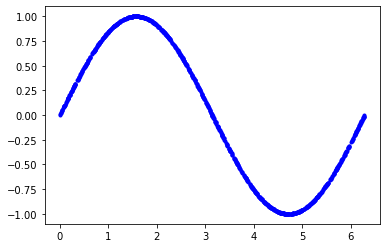

In [3]:
# We'll generate this many sample datapoints
SAMPLES = 1000

# Set a "seed" value, so we get the same random numbers each time we run this
# notebook
np.random.seed(1337)

# Generate a uniformly distributed set of random numbers in the range from
# 0 to 2π, which covers a complete sine wave oscillation
x_values = np.random.uniform(low=0, high=2*math.pi, size=SAMPLES)

# Shuffle the values to guarantee they're not in order
np.random.shuffle(x_values)

# Calculate the corresponding sine values
y_values = np.sin(x_values)

# Plot our data. The 'b.' argument tells the library to print blue dots.
plt.plot(x_values, y_values, 'b.')
plt.show()

## Add some noise
Since it was generated directly by the sine function, our data fits a nice, smooth curve.

However, machine learning models are good at extracting underlying meaning from messy, real world data. To demonstrate this, we can add some noise to our data to approximate something more life-like.

In the following cell, we'll add some random noise to each value, then draw a new graph:

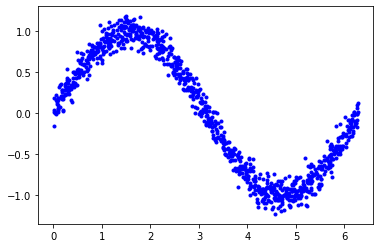

In [4]:
# Add a small random number to each y value
y_values += 0.1 * np.random.randn(*y_values.shape)

# Plot our data
plt.plot(x_values, y_values, 'b.')
plt.show()

## Split our data
We now have a noisy dataset that approximates real world data. We'll be using this to train our model.

To evaluate the accuracy of the model we train, we'll need to compare its predictions to real data and check how well they match up. This evaluation happens during training (where it is referred to as validation) and after training (referred to as testing) It's important in both cases that we use fresh data that was not already used to train the model.

To ensure we have data to use for evaluation, we'll set some aside before we begin training. We'll reserve 20% of our data for validation, and another 20% for testing. The remaining 60% will be used to train the model. This is a typical split used when training models.

The following code will split our data and then plot each set as a different color:


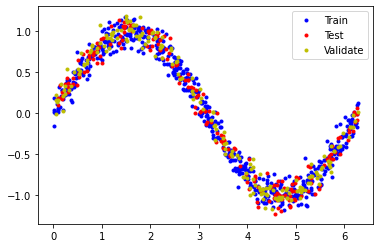

In [5]:
# We'll use 60% of our data for training and 20% for testing. The remaining 20%
# will be used for validation. Calculate the indices of each section.
TRAIN_SPLIT =  int(0.6 * SAMPLES)
TEST_SPLIT = int(0.2 * SAMPLES + TRAIN_SPLIT)

# Use np.split to chop our data into three parts.
# The second argument to np.split is an array of indices where the data will be
# split. We provide two indices, so the data will be divided into three chunks.
x_train, x_test, x_validate = np.split(x_values, [TRAIN_SPLIT, TEST_SPLIT])
y_train, y_test, y_validate = np.split(y_values, [TRAIN_SPLIT, TEST_SPLIT])

# Double check that our splits add up correctly
assert (x_train.size + x_validate.size + x_test.size) ==  SAMPLES

# Plot the data in each partition in different colors:
plt.plot(x_train, y_train, 'b.', label="Train")
plt.plot(x_test, y_test, 'r.', label="Test")
plt.plot(x_validate, y_validate, 'y.', label="Validate")
plt.legend()
plt.show()


## Design a model
We're going to build a model that will take an input value (in this case, `x`) and use it to predict a numeric output value (the sine of `x`). This type of problem is called a _regression_.

To achieve this, we're going to create a simple neural network. It will use _layers_ of _neurons_ to attempt to learn any patterns underlying the training data, so it can make predictions.

To begin with, we'll define two layers. The first layer takes a single input (our `x` value) and runs it through 16 neurons. Based on this input, each neuron will become _activated_ to a certain degree based on its internal state (its _weight_ and _bias_ values). A neuron's degree of activation is expressed as a number.

The activation numbers from our first layer will be fed as inputs to our second layer, which is a single neuron. It will apply its own weights and bias to these inputs and calculate its own activation, which will be output as our `y` value.

**Note:** To learn more about how neural networks function, you can explore the [Learn TensorFlow](https://codelabs.developers.google.com/codelabs/tensorflow-lab1-helloworld) codelabs.

The code in the following cell defines our model using [Keras](https://www.tensorflow.org/guide/keras), TensorFlow's high-level API for creating deep learning networks. Once the network is defined, we _compile_ it, specifying parameters that determine how it will be trained:

In [6]:
# We'll use Keras to create a simple model architecture
from tensorflow.keras import layers
model_1 = tf.keras.Sequential()

# First layer takes a scalar input and feeds it through 16 "neurons". The
# neurons decide whether to activate based on the 'relu' activation function.
model_1.add(layers.Dense(16, activation='relu', input_shape=(1,)))

# Final layer is a single neuron, since we want to output a single value
model_1.add(layers.Dense(1))

# Compile the model using a standard optimizer and loss function for regression
model_1.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

## Train the model
Once we've defined the model, we can use our data to _train_ it. Training involves passing an `x` value into the neural network, checking how far the network's output deviates from the expected `y` value, and adjusting the neurons' weights and biases so that the output is more likely to be correct the next time.

Training runs this process on the full dataset multiple times, and each full run-through is known as an _epoch_. The number of epochs to run during training is a parameter we can set.

During each epoch, data is run through the network in multiple _batches_. Each batch, several pieces of data are passed into the network, producing output values. These outputs' correctness is measured in aggregate and the network's weights and biases are adjusted accordingly, once per batch. The _batch size_ is also a parameter we can set.

The code in the following cell uses the `x` and `y` values from our training data to train the model. It runs for 1000 _epochs_, with 16 pieces of data in each _batch_. We also pass in some data to use for _validation_. As you will see when you run the cell, training can take a while to complete:



In [7]:
# Train the model on our training data while validating on our validation set
history_1 = model_1.fit(x_train, y_train, epochs=1000, batch_size=16,
                    validation_data=(x_validate, y_validate))

Epoch 1/1000
38/38 [==============================] - 0s 5ms/step - loss: 6.0858 - mae: 1.9244 - val_loss: 4.2417 - val_mae: 1.6373
Epoch 2/1000
38/38 [==============================] - 0s 2ms/step - loss: 2.8778 - mae: 1.3691 - val_loss: 1.9775 - val_mae: 1.2225
Epoch 3/1000
38/38 [==============================] - 0s 2ms/step - loss: 1.2630 - mae: 0.9925 - val_loss: 0.9544 - val_mae: 0.9162
Epoch 4/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.6816 - mae: 0.7490 - val_loss: 0.6844 - val_mae: 0.7423
Epoch 5/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.5496 - mae: 0.6487 - val_loss: 0.5989 - val_mae: 0.6661
Epoch 6/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.4925 - mae: 0.6063 - val_loss: 0.5452 - val_mae: 0.6535
Epoch 7/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.4412 - mae: 0.5766 - val_loss: 0.4882 - val_mae: 0.6122
Epoch 8/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.

38/38 [==============================] - 0s 2ms/step - loss: 0.1626 - mae: 0.3348 - val_loss: 0.1674 - val_mae: 0.3464
Epoch 63/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.1629 - mae: 0.3367 - val_loss: 0.1604 - val_mae: 0.3382
Epoch 64/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.1631 - mae: 0.3347 - val_loss: 0.1603 - val_mae: 0.3378
Epoch 65/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.1613 - mae: 0.3332 - val_loss: 0.1628 - val_mae: 0.3413
Epoch 66/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.1629 - mae: 0.3349 - val_loss: 0.1620 - val_mae: 0.3403
Epoch 67/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.1621 - mae: 0.3332 - val_loss: 0.1613 - val_mae: 0.3392
Epoch 68/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.1627 - mae: 0.3331 - val_loss: 0.1648 - val_mae: 0.3426
Epoch 69/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.1615 -

38/38 [==============================] - 0s 2ms/step - loss: 0.1593 - mae: 0.3245 - val_loss: 0.1575 - val_mae: 0.3312
Epoch 124/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.1586 - mae: 0.3242 - val_loss: 0.1550 - val_mae: 0.3280
Epoch 125/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.1574 - mae: 0.3227 - val_loss: 0.1559 - val_mae: 0.3279
Epoch 126/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.1594 - mae: 0.3230 - val_loss: 0.1548 - val_mae: 0.3276
Epoch 127/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.1586 - mae: 0.3235 - val_loss: 0.1630 - val_mae: 0.3353
Epoch 128/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.1586 - mae: 0.3245 - val_loss: 0.1637 - val_mae: 0.3359
Epoch 129/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.1589 - mae: 0.3243 - val_loss: 0.1568 - val_mae: 0.3301
Epoch 130/1000
38/38 [==============================] - 0s 2ms/step - loss: 0

38/38 [==============================] - 0s 1ms/step - loss: 0.1568 - mae: 0.3186 - val_loss: 0.1534 - val_mae: 0.3232
Epoch 185/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.1574 - mae: 0.3184 - val_loss: 0.1570 - val_mae: 0.3266
Epoch 186/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.1575 - mae: 0.3194 - val_loss: 0.1525 - val_mae: 0.3217
Epoch 187/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.1584 - mae: 0.3177 - val_loss: 0.1523 - val_mae: 0.3211
Epoch 188/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.1582 - mae: 0.3186 - val_loss: 0.1549 - val_mae: 0.3245
Epoch 189/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.1572 - mae: 0.3199 - val_loss: 0.1539 - val_mae: 0.3234
Epoch 190/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.1574 - mae: 0.3183 - val_loss: 0.1532 - val_mae: 0.3225
Epoch 191/1000
38/38 [==============================] - 0s 2ms/step - loss: 0

38/38 [==============================] - 0s 2ms/step - loss: 0.1547 - mae: 0.3119 - val_loss: 0.1528 - val_mae: 0.3197
Epoch 246/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.1552 - mae: 0.3146 - val_loss: 0.1535 - val_mae: 0.3204
Epoch 247/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.1560 - mae: 0.3139 - val_loss: 0.1525 - val_mae: 0.3192
Epoch 248/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.1564 - mae: 0.3144 - val_loss: 0.1552 - val_mae: 0.3218
Epoch 249/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.1541 - mae: 0.3133 - val_loss: 0.1598 - val_mae: 0.3255
Epoch 250/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.1564 - mae: 0.3155 - val_loss: 0.1654 - val_mae: 0.3300
Epoch 251/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.1556 - mae: 0.3154 - val_loss: 0.1581 - val_mae: 0.3239
Epoch 252/1000
38/38 [==============================] - 0s 2ms/step - loss: 0

38/38 [==============================] - 0s 2ms/step - loss: 0.1557 - mae: 0.3123 - val_loss: 0.1588 - val_mae: 0.3232
Epoch 307/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.1553 - mae: 0.3128 - val_loss: 0.1564 - val_mae: 0.3213
Epoch 308/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.1546 - mae: 0.3112 - val_loss: 0.1527 - val_mae: 0.3184
Epoch 309/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.1564 - mae: 0.3145 - val_loss: 0.1528 - val_mae: 0.3181
Epoch 310/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.1551 - mae: 0.3138 - val_loss: 0.1535 - val_mae: 0.3183
Epoch 311/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.1553 - mae: 0.3126 - val_loss: 0.1534 - val_mae: 0.3185
Epoch 312/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.1558 - mae: 0.3148 - val_loss: 0.1510 - val_mae: 0.3149
Epoch 313/1000
38/38 [==============================] - 0s 2ms/step - loss: 0

38/38 [==============================] - 0s 3ms/step - loss: 0.1552 - mae: 0.3117 - val_loss: 0.1500 - val_mae: 0.3129
Epoch 368/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.1555 - mae: 0.3105 - val_loss: 0.1515 - val_mae: 0.3149
Epoch 369/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.1554 - mae: 0.3127 - val_loss: 0.1521 - val_mae: 0.3159
Epoch 370/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.1549 - mae: 0.3125 - val_loss: 0.1516 - val_mae: 0.3150
Epoch 371/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.1562 - mae: 0.3117 - val_loss: 0.1536 - val_mae: 0.3169
Epoch 372/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.1527 - mae: 0.3078 - val_loss: 0.1521 - val_mae: 0.3161
Epoch 373/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.1544 - mae: 0.3117 - val_loss: 0.1498 - val_mae: 0.3128
Epoch 374/1000
38/38 [==============================] - 0s 3ms/step - loss: 0

38/38 [==============================] - 0s 3ms/step - loss: 0.1530 - mae: 0.3083 - val_loss: 0.1692 - val_mae: 0.3284
Epoch 429/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.1564 - mae: 0.3130 - val_loss: 0.1498 - val_mae: 0.3125
Epoch 430/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.1561 - mae: 0.3103 - val_loss: 0.1526 - val_mae: 0.3152
Epoch 431/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.1552 - mae: 0.3120 - val_loss: 0.1529 - val_mae: 0.3153
Epoch 432/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.1540 - mae: 0.3097 - val_loss: 0.1680 - val_mae: 0.3272
Epoch 433/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.1549 - mae: 0.3109 - val_loss: 0.1551 - val_mae: 0.3170
Epoch 434/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.1550 - mae: 0.3103 - val_loss: 0.1495 - val_mae: 0.3116
Epoch 435/1000
38/38 [==============================] - 0s 3ms/step - loss: 0

38/38 [==============================] - 0s 2ms/step - loss: 0.1537 - mae: 0.3101 - val_loss: 0.1495 - val_mae: 0.3114
Epoch 490/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.1548 - mae: 0.3105 - val_loss: 0.1498 - val_mae: 0.3117
Epoch 491/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.1546 - mae: 0.3106 - val_loss: 0.1493 - val_mae: 0.3109
Epoch 492/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.1525 - mae: 0.3052 - val_loss: 0.1563 - val_mae: 0.3175
Epoch 493/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.1544 - mae: 0.3097 - val_loss: 0.1495 - val_mae: 0.3112
Epoch 494/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.1546 - mae: 0.3087 - val_loss: 0.1525 - val_mae: 0.3145
Epoch 495/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.1536 - mae: 0.3083 - val_loss: 0.1577 - val_mae: 0.3190
Epoch 496/1000
38/38 [==============================] - 0s 2ms/step - loss: 0

38/38 [==============================] - 0s 2ms/step - loss: 0.1551 - mae: 0.3100 - val_loss: 0.1556 - val_mae: 0.3157
Epoch 551/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.1544 - mae: 0.3078 - val_loss: 0.1489 - val_mae: 0.3097
Epoch 552/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.1558 - mae: 0.3085 - val_loss: 0.1490 - val_mae: 0.3099
Epoch 553/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.1538 - mae: 0.3075 - val_loss: 0.1533 - val_mae: 0.3142
Epoch 554/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.1543 - mae: 0.3100 - val_loss: 0.1571 - val_mae: 0.3174
Epoch 555/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.1544 - mae: 0.3086 - val_loss: 0.1492 - val_mae: 0.3105
Epoch 556/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.1537 - mae: 0.3087 - val_loss: 0.1493 - val_mae: 0.3108
Epoch 557/1000
38/38 [==============================] - 0s 3ms/step - loss: 0

Epoch 611/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.1557 - mae: 0.3103 - val_loss: 0.1537 - val_mae: 0.3144
Epoch 612/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.1534 - mae: 0.3065 - val_loss: 0.1619 - val_mae: 0.3213
Epoch 613/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.1532 - mae: 0.3083 - val_loss: 0.1513 - val_mae: 0.3126
Epoch 614/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.1554 - mae: 0.3103 - val_loss: 0.1510 - val_mae: 0.3124
Epoch 615/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.1549 - mae: 0.3103 - val_loss: 0.1491 - val_mae: 0.3101
Epoch 616/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.1531 - mae: 0.3064 - val_loss: 0.1510 - val_mae: 0.3124
Epoch 617/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.1547 - mae: 0.3089 - val_loss: 0.1497 - val_mae: 0.3111
Epoch 618/1000
38/38 [==============================] - 0s 2ms

38/38 [==============================] - 0s 3ms/step - loss: 0.1545 - mae: 0.3078 - val_loss: 0.1508 - val_mae: 0.3114
Epoch 673/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.1552 - mae: 0.3080 - val_loss: 0.1489 - val_mae: 0.3093
Epoch 674/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.1540 - mae: 0.3072 - val_loss: 0.1624 - val_mae: 0.3210
Epoch 675/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.1543 - mae: 0.3083 - val_loss: 0.1509 - val_mae: 0.3121
Epoch 676/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.1543 - mae: 0.3081 - val_loss: 0.1496 - val_mae: 0.3108
Epoch 677/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.1540 - mae: 0.3077 - val_loss: 0.1556 - val_mae: 0.3159
Epoch 678/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.1533 - mae: 0.3060 - val_loss: 0.1512 - val_mae: 0.3118
Epoch 679/1000
38/38 [==============================] - 0s 3ms/step - loss: 0

38/38 [==============================] - 0s 2ms/step - loss: 0.1543 - mae: 0.3077 - val_loss: 0.1550 - val_mae: 0.3146
Epoch 734/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.1535 - mae: 0.3083 - val_loss: 0.1494 - val_mae: 0.3093
Epoch 735/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.1548 - mae: 0.3079 - val_loss: 0.1487 - val_mae: 0.3084
Epoch 736/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.1538 - mae: 0.3071 - val_loss: 0.1541 - val_mae: 0.3133
Epoch 737/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.1516 - mae: 0.3052 - val_loss: 0.1580 - val_mae: 0.3113
Epoch 738/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.1550 - mae: 0.3080 - val_loss: 0.1561 - val_mae: 0.3108
Epoch 739/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.1543 - mae: 0.3069 - val_loss: 0.1486 - val_mae: 0.3083
Epoch 740/1000
38/38 [==============================] - 0s 2ms/step - loss: 0

38/38 [==============================] - 0s 2ms/step - loss: 0.1542 - mae: 0.3063 - val_loss: 0.1504 - val_mae: 0.3103
Epoch 795/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.1533 - mae: 0.3075 - val_loss: 0.1486 - val_mae: 0.3083
Epoch 796/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.1545 - mae: 0.3062 - val_loss: 0.1485 - val_mae: 0.3081
Epoch 797/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.1549 - mae: 0.3062 - val_loss: 0.1584 - val_mae: 0.3172
Epoch 798/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.1548 - mae: 0.3082 - val_loss: 0.1585 - val_mae: 0.3172
Epoch 799/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.1536 - mae: 0.3067 - val_loss: 0.1497 - val_mae: 0.3099
Epoch 800/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.1538 - mae: 0.3080 - val_loss: 0.1498 - val_mae: 0.3087
Epoch 801/1000
38/38 [==============================] - 0s 2ms/step - loss: 0

38/38 [==============================] - 0s 2ms/step - loss: 0.1539 - mae: 0.3075 - val_loss: 0.1577 - val_mae: 0.3174
Epoch 856/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.1540 - mae: 0.3074 - val_loss: 0.1494 - val_mae: 0.3099
Epoch 857/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.1531 - mae: 0.3082 - val_loss: 0.1502 - val_mae: 0.3095
Epoch 858/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.1547 - mae: 0.3068 - val_loss: 0.1645 - val_mae: 0.3225
Epoch 859/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.1532 - mae: 0.3081 - val_loss: 0.1526 - val_mae: 0.3111
Epoch 860/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.1538 - mae: 0.3048 - val_loss: 0.1514 - val_mae: 0.3117
Epoch 861/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.1528 - mae: 0.3083 - val_loss: 0.1524 - val_mae: 0.3102
Epoch 862/1000
38/38 [==============================] - 0s 2ms/step - loss: 0

38/38 [==============================] - 0s 2ms/step - loss: 0.1532 - mae: 0.3048 - val_loss: 0.1525 - val_mae: 0.3118
Epoch 917/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.1535 - mae: 0.3083 - val_loss: 0.1503 - val_mae: 0.3103
Epoch 918/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.1520 - mae: 0.3045 - val_loss: 0.1493 - val_mae: 0.3092
Epoch 919/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.1539 - mae: 0.3059 - val_loss: 0.1506 - val_mae: 0.3107
Epoch 920/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.1535 - mae: 0.3051 - val_loss: 0.1521 - val_mae: 0.3118
Epoch 921/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.1534 - mae: 0.3063 - val_loss: 0.1511 - val_mae: 0.3114
Epoch 922/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.1558 - mae: 0.3087 - val_loss: 0.1492 - val_mae: 0.3094
Epoch 923/1000
38/38 [==============================] - 0s 2ms/step - loss: 0

38/38 [==============================] - 0s 2ms/step - loss: 0.1542 - mae: 0.3080 - val_loss: 0.1516 - val_mae: 0.3123
Epoch 978/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.1539 - mae: 0.3076 - val_loss: 0.1495 - val_mae: 0.3102
Epoch 979/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.1535 - mae: 0.3076 - val_loss: 0.1489 - val_mae: 0.3092
Epoch 980/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.1549 - mae: 0.3087 - val_loss: 0.1512 - val_mae: 0.3115
Epoch 981/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.1536 - mae: 0.3074 - val_loss: 0.1498 - val_mae: 0.3091
Epoch 982/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.1538 - mae: 0.3076 - val_loss: 0.1497 - val_mae: 0.3093
Epoch 983/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.1537 - mae: 0.3053 - val_loss: 0.1501 - val_mae: 0.3106
Epoch 984/1000
38/38 [==============================] - 0s 3ms/step - loss: 0

## Check the training metrics
During training, the model's performance is constantly being measured against both our training data and the validation data that we set aside earlier. Training produces a log of data that tells us how the model's performance changed over the course of the training process.

The following cells will display some of that data in a graphical form:

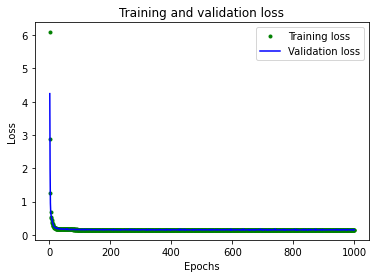

In [8]:
# Draw a graph of the loss, which is the distance between
# the predicted and actual values during training and validation.
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Look closer at the data
The graph shows the _loss_ (or the difference between the model's predictions and the actual data) for each epoch. There are several ways to calculate loss, and the method we have used is _mean squared error_. There is a distinct loss value given for the training and the validation data.

As we can see, the amount of loss rapidly decreases over the first 25 epochs, before flattening out. This means that the model is improving and producing more accurate predictions!

Our goal is to stop training when either the model is no longer improving, or when the _training loss_ is less than the _validation loss_, which would mean that the model has learned to predict the training data so well that it can no longer generalize to new data.

To make the flatter part of the graph more readable, let's skip the first 50 epochs:

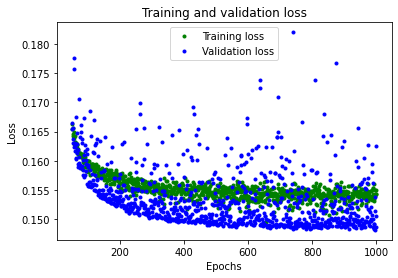

In [9]:
# Exclude the first few epochs so the graph is easier to read
SKIP = 50

plt.plot(epochs[SKIP:], loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Further metrics
From the plot, we can see that loss continues to reduce until around 600 epochs, at which point it is mostly stable. This means that there's no need to train our network beyond 600 epochs.

However, we can also see that the lowest loss value is still around 0.155. This means that our network's predictions are off by an average of ~15%. In addition, the validation loss values jump around a lot, and is sometimes even higher.

To gain more insight into our model's performance we can plot some more data. This time, we'll plot the _mean absolute error_, which is another way of measuring how far the network's predictions are from the actual numbers:


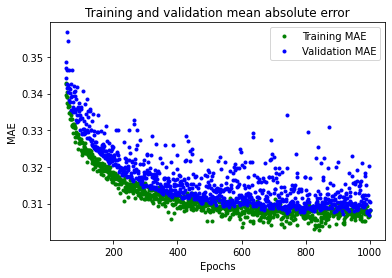

In [10]:
plt.clf()

# Draw a graph of mean absolute error, which is another way of
# measuring the amount of error in the prediction.
mae = history_1.history['mae']
val_mae = history_1.history['val_mae']

plt.plot(epochs[SKIP:], mae[SKIP:], 'g.', label='Training MAE')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='Validation MAE')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

This graph of _mean absolute error_ tells another story. We can see that training data shows consistently lower error than validation data, which means that the network may have _overfit_, or learned the training data so rigidly that it can't make effective predictions about new data.

In addition, the mean absolute error values are quite high, ~0.305 at best, which means some of the model's predictions are at least 30% off. A 30% error means we are very far from accurately modelling the sine wave function.

To get more insight into what is happening, we can plot our network's predictions for the training data against the expected values:

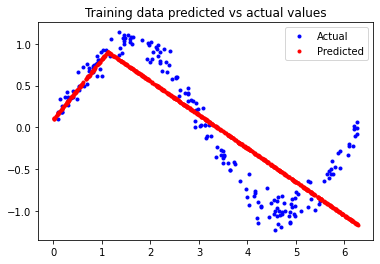

In [11]:
# Use the model to make predictions from our validation data
predictions = model_1.predict(x_train)

# Plot the predictions along with to the test data
plt.clf()
plt.title('Training data predicted vs actual values')
plt.plot(x_test, y_test, 'b.', label='Actual')
plt.plot(x_train, predictions, 'r.', label='Predicted')
plt.legend()
plt.show()

Oh dear! The graph makes it clear that our network has learned to approximate the sine function in a very limited way. From `0 <= x <= 1.1` the line mostly fits, but for the rest of our `x` values it is a rough approximation at best.

The rigidity of this fit suggests that the model does not have enough capacity to learn the full complexity of the sine wave function, so it's only able to approximate it in an overly simplistic way. By making our model bigger, we should be able to improve its performance.

## Change our model
To make our model bigger, let's add an additional layer of neurons. The following cell redefines our model in the same way as earlier, but with an additional layer of 16 neurons in the middle:

In [12]:
model_2 = tf.keras.Sequential()

# First layer takes a scalar input and feeds it through 16 "neurons". The
# neurons decide whether to activate based on the 'relu' activation function.
model_2.add(layers.Dense(16, activation='relu', input_shape=(1,)))

# The new second layer may help the network learn more complex representations
model_2.add(layers.Dense(16, activation='relu'))

# Final layer is a single neuron, since we want to output a single value
model_2.add(layers.Dense(1))

# Compile the model using a standard optimizer and loss function for regression
model_2.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

We'll now train the new model. To save time, we'll train for only 600 epochs:

In [13]:
history_2 = model_2.fit(x_train, y_train, epochs=600, batch_size=16,
                    validation_data=(x_validate, y_validate))

Epoch 1/600
38/38 [==============================] - 0s 3ms/step - loss: 0.5827 - mae: 0.6690 - val_loss: 0.5118 - val_mae: 0.6404
Epoch 2/600
38/38 [==============================] - 0s 2ms/step - loss: 0.3887 - mae: 0.5439 - val_loss: 0.4057 - val_mae: 0.5523
Epoch 3/600
38/38 [==============================] - 0s 2ms/step - loss: 0.3230 - mae: 0.4928 - val_loss: 0.3473 - val_mae: 0.5178
Epoch 4/600
38/38 [==============================] - 0s 2ms/step - loss: 0.2712 - mae: 0.4539 - val_loss: 0.2859 - val_mae: 0.4629
Epoch 5/600
38/38 [==============================] - 0s 2ms/step - loss: 0.2309 - mae: 0.4219 - val_loss: 0.2417 - val_mae: 0.4266
Epoch 6/600
38/38 [==============================] - 0s 3ms/step - loss: 0.2014 - mae: 0.3945 - val_loss: 0.2120 - val_mae: 0.4089
Epoch 7/600
38/38 [==============================] - 0s 2ms/step - loss: 0.1824 - mae: 0.3773 - val_loss: 0.1946 - val_mae: 0.3928
Epoch 8/600
38/38 [==============================] - 0s 2ms/step - loss: 0.1703 - m

38/38 [==============================] - 0s 2ms/step - loss: 0.0355 - mae: 0.1400 - val_loss: 0.0369 - val_mae: 0.1496
Epoch 64/600
38/38 [==============================] - 0s 3ms/step - loss: 0.0344 - mae: 0.1401 - val_loss: 0.0271 - val_mae: 0.1216
Epoch 65/600
38/38 [==============================] - 0s 3ms/step - loss: 0.0340 - mae: 0.1387 - val_loss: 0.0264 - val_mae: 0.1206
Epoch 66/600
38/38 [==============================] - 0s 3ms/step - loss: 0.0319 - mae: 0.1333 - val_loss: 0.0277 - val_mae: 0.1299
Epoch 67/600
38/38 [==============================] - 0s 2ms/step - loss: 0.0311 - mae: 0.1351 - val_loss: 0.0307 - val_mae: 0.1214
Epoch 68/600
38/38 [==============================] - 0s 3ms/step - loss: 0.0306 - mae: 0.1316 - val_loss: 0.0251 - val_mae: 0.1235
Epoch 69/600
38/38 [==============================] - 0s 3ms/step - loss: 0.0294 - mae: 0.1306 - val_loss: 0.0296 - val_mae: 0.1360
Epoch 70/600
38/38 [==============================] - 0s 3ms/step - loss: 0.0290 - mae: 0

Epoch 125/600
38/38 [==============================] - 0s 3ms/step - loss: 0.0132 - mae: 0.0924 - val_loss: 0.0102 - val_mae: 0.0792
Epoch 126/600
38/38 [==============================] - 0s 3ms/step - loss: 0.0135 - mae: 0.0938 - val_loss: 0.0107 - val_mae: 0.0814
Epoch 127/600
38/38 [==============================] - 0s 3ms/step - loss: 0.0127 - mae: 0.0902 - val_loss: 0.0122 - val_mae: 0.0877
Epoch 128/600
38/38 [==============================] - 0s 3ms/step - loss: 0.0133 - mae: 0.0919 - val_loss: 0.0094 - val_mae: 0.0763
Epoch 129/600
38/38 [==============================] - 0s 3ms/step - loss: 0.0133 - mae: 0.0924 - val_loss: 0.0123 - val_mae: 0.0879
Epoch 130/600
38/38 [==============================] - 0s 3ms/step - loss: 0.0132 - mae: 0.0925 - val_loss: 0.0115 - val_mae: 0.0842
Epoch 131/600
38/38 [==============================] - 0s 3ms/step - loss: 0.0131 - mae: 0.0913 - val_loss: 0.0098 - val_mae: 0.0769
Epoch 132/600
38/38 [==============================] - 0s 3ms/step - 

38/38 [==============================] - 0s 2ms/step - loss: 0.0123 - mae: 0.0889 - val_loss: 0.0114 - val_mae: 0.0845
Epoch 187/600
38/38 [==============================] - 0s 2ms/step - loss: 0.0124 - mae: 0.0896 - val_loss: 0.0112 - val_mae: 0.0825
Epoch 188/600
38/38 [==============================] - 0s 3ms/step - loss: 0.0127 - mae: 0.0908 - val_loss: 0.0097 - val_mae: 0.0764
Epoch 189/600
38/38 [==============================] - 0s 3ms/step - loss: 0.0119 - mae: 0.0874 - val_loss: 0.0123 - val_mae: 0.0863
Epoch 190/600
38/38 [==============================] - 0s 2ms/step - loss: 0.0123 - mae: 0.0891 - val_loss: 0.0102 - val_mae: 0.0779
Epoch 191/600
38/38 [==============================] - 0s 3ms/step - loss: 0.0123 - mae: 0.0895 - val_loss: 0.0104 - val_mae: 0.0792
Epoch 192/600
38/38 [==============================] - 0s 2ms/step - loss: 0.0124 - mae: 0.0894 - val_loss: 0.0130 - val_mae: 0.0889
Epoch 193/600
38/38 [==============================] - 0s 2ms/step - loss: 0.0124 -

Epoch 248/600
38/38 [==============================] - 0s 2ms/step - loss: 0.0122 - mae: 0.0887 - val_loss: 0.0113 - val_mae: 0.0827
Epoch 249/600
38/38 [==============================] - 0s 3ms/step - loss: 0.0117 - mae: 0.0877 - val_loss: 0.0099 - val_mae: 0.0769
Epoch 250/600
38/38 [==============================] - 0s 3ms/step - loss: 0.0124 - mae: 0.0898 - val_loss: 0.0211 - val_mae: 0.1130
Epoch 251/600
38/38 [==============================] - 0s 3ms/step - loss: 0.0123 - mae: 0.0886 - val_loss: 0.0089 - val_mae: 0.0731
Epoch 252/600
38/38 [==============================] - 0s 2ms/step - loss: 0.0123 - mae: 0.0889 - val_loss: 0.0085 - val_mae: 0.0712
Epoch 253/600
38/38 [==============================] - 0s 3ms/step - loss: 0.0123 - mae: 0.0880 - val_loss: 0.0116 - val_mae: 0.0853
Epoch 254/600
38/38 [==============================] - 0s 3ms/step - loss: 0.0120 - mae: 0.0878 - val_loss: 0.0104 - val_mae: 0.0788
Epoch 255/600
38/38 [==============================] - 0s 3ms/step - 

38/38 [==============================] - 0s 3ms/step - loss: 0.0120 - mae: 0.0875 - val_loss: 0.0136 - val_mae: 0.0920
Epoch 310/600
38/38 [==============================] - 0s 2ms/step - loss: 0.0124 - mae: 0.0898 - val_loss: 0.0151 - val_mae: 0.0961
Epoch 311/600
38/38 [==============================] - 0s 3ms/step - loss: 0.0121 - mae: 0.0880 - val_loss: 0.0084 - val_mae: 0.0704
Epoch 312/600
38/38 [==============================] - 0s 2ms/step - loss: 0.0118 - mae: 0.0877 - val_loss: 0.0107 - val_mae: 0.0803
Epoch 313/600
38/38 [==============================] - 0s 3ms/step - loss: 0.0119 - mae: 0.0866 - val_loss: 0.0118 - val_mae: 0.0859
Epoch 314/600
38/38 [==============================] - 0s 3ms/step - loss: 0.0123 - mae: 0.0885 - val_loss: 0.0156 - val_mae: 0.0999
Epoch 315/600
38/38 [==============================] - 0s 3ms/step - loss: 0.0117 - mae: 0.0871 - val_loss: 0.0096 - val_mae: 0.0777
Epoch 316/600
38/38 [==============================] - 0s 3ms/step - loss: 0.0123 -

Epoch 371/600
38/38 [==============================] - 0s 3ms/step - loss: 0.0119 - mae: 0.0871 - val_loss: 0.0112 - val_mae: 0.0840
Epoch 372/600
38/38 [==============================] - 0s 2ms/step - loss: 0.0119 - mae: 0.0871 - val_loss: 0.0098 - val_mae: 0.0771
Epoch 373/600
38/38 [==============================] - 0s 3ms/step - loss: 0.0116 - mae: 0.0865 - val_loss: 0.0095 - val_mae: 0.0765
Epoch 374/600
38/38 [==============================] - 0s 3ms/step - loss: 0.0124 - mae: 0.0898 - val_loss: 0.0089 - val_mae: 0.0720
Epoch 375/600
38/38 [==============================] - 0s 3ms/step - loss: 0.0113 - mae: 0.0862 - val_loss: 0.0091 - val_mae: 0.0742
Epoch 376/600
38/38 [==============================] - 0s 2ms/step - loss: 0.0122 - mae: 0.0884 - val_loss: 0.0114 - val_mae: 0.0846
Epoch 377/600
38/38 [==============================] - 0s 3ms/step - loss: 0.0117 - mae: 0.0878 - val_loss: 0.0208 - val_mae: 0.1125
Epoch 378/600
38/38 [==============================] - 0s 3ms/step - 

38/38 [==============================] - 0s 2ms/step - loss: 0.0117 - mae: 0.0880 - val_loss: 0.0085 - val_mae: 0.0710
Epoch 433/600
38/38 [==============================] - 0s 3ms/step - loss: 0.0117 - mae: 0.0868 - val_loss: 0.0085 - val_mae: 0.0707
Epoch 434/600
38/38 [==============================] - 0s 3ms/step - loss: 0.0119 - mae: 0.0885 - val_loss: 0.0133 - val_mae: 0.0918
Epoch 435/600
38/38 [==============================] - 0s 3ms/step - loss: 0.0118 - mae: 0.0879 - val_loss: 0.0088 - val_mae: 0.0723
Epoch 436/600
38/38 [==============================] - 0s 2ms/step - loss: 0.0120 - mae: 0.0878 - val_loss: 0.0098 - val_mae: 0.0776
Epoch 437/600
38/38 [==============================] - 0s 3ms/step - loss: 0.0120 - mae: 0.0876 - val_loss: 0.0105 - val_mae: 0.0802
Epoch 438/600
38/38 [==============================] - 0s 2ms/step - loss: 0.0118 - mae: 0.0875 - val_loss: 0.0103 - val_mae: 0.0792
Epoch 439/600
38/38 [==============================] - 0s 2ms/step - loss: 0.0125 -

Epoch 494/600
38/38 [==============================] - 0s 3ms/step - loss: 0.0118 - mae: 0.0865 - val_loss: 0.0114 - val_mae: 0.0840
Epoch 495/600
38/38 [==============================] - 0s 3ms/step - loss: 0.0124 - mae: 0.0886 - val_loss: 0.0106 - val_mae: 0.0796
Epoch 496/600
38/38 [==============================] - 0s 3ms/step - loss: 0.0126 - mae: 0.0899 - val_loss: 0.0088 - val_mae: 0.0726
Epoch 497/600
38/38 [==============================] - 0s 2ms/step - loss: 0.0121 - mae: 0.0885 - val_loss: 0.0090 - val_mae: 0.0736
Epoch 498/600
38/38 [==============================] - 0s 2ms/step - loss: 0.0116 - mae: 0.0865 - val_loss: 0.0092 - val_mae: 0.0750
Epoch 499/600
38/38 [==============================] - 0s 3ms/step - loss: 0.0120 - mae: 0.0873 - val_loss: 0.0082 - val_mae: 0.0688
Epoch 500/600
38/38 [==============================] - 0s 3ms/step - loss: 0.0118 - mae: 0.0870 - val_loss: 0.0088 - val_mae: 0.0724
Epoch 501/600
38/38 [==============================] - 0s 3ms/step - 

38/38 [==============================] - 0s 2ms/step - loss: 0.0122 - mae: 0.0891 - val_loss: 0.0100 - val_mae: 0.0780
Epoch 556/600
38/38 [==============================] - 0s 2ms/step - loss: 0.0125 - mae: 0.0912 - val_loss: 0.0094 - val_mae: 0.0759
Epoch 557/600
38/38 [==============================] - 0s 2ms/step - loss: 0.0121 - mae: 0.0886 - val_loss: 0.0087 - val_mae: 0.0719
Epoch 558/600
38/38 [==============================] - 0s 2ms/step - loss: 0.0122 - mae: 0.0888 - val_loss: 0.0135 - val_mae: 0.0925
Epoch 559/600
38/38 [==============================] - 0s 2ms/step - loss: 0.0118 - mae: 0.0873 - val_loss: 0.0089 - val_mae: 0.0734
Epoch 560/600
38/38 [==============================] - 0s 3ms/step - loss: 0.0122 - mae: 0.0883 - val_loss: 0.0101 - val_mae: 0.0785
Epoch 561/600
38/38 [==============================] - 0s 2ms/step - loss: 0.0118 - mae: 0.0870 - val_loss: 0.0087 - val_mae: 0.0723
Epoch 562/600
38/38 [==============================] - 0s 3ms/step - loss: 0.0121 -

## Evaluate our new model
Each training epoch, the model prints out its loss and mean absolute error for training and validation. You can read this in the output above (note that your exact numbers may differ): 

```
Epoch 600/600
600/600 [==============================] - 0s 109us/sample - loss: 0.0124 - mae: 0.0892 - val_loss: 0.0116 - val_mae: 0.0845
```

You can see that we've already got a huge improvement - validation loss has dropped from 0.15 to 0.015, and validation MAE has dropped from 0.31 to 0.1.

The following cell will print the same graphs we used to evaluate our original model, but showing our new training history:

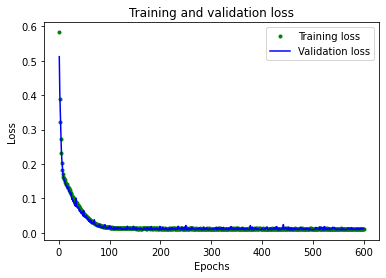

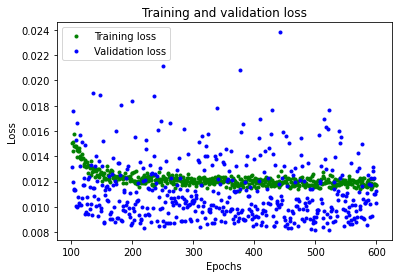

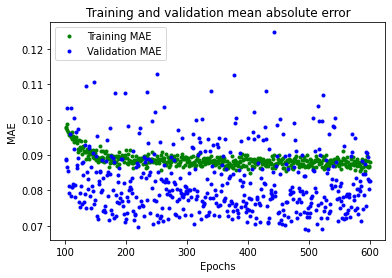

In [14]:
# Draw a graph of the loss, which is the distance between
# the predicted and actual values during training and validation.
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Exclude the first few epochs so the graph is easier to read
SKIP = 100

plt.clf()

plt.plot(epochs[SKIP:], loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.clf()

# Draw a graph of mean absolute error, which is another way of
# measuring the amount of error in the prediction.
mae = history_2.history['mae']
val_mae = history_2.history['val_mae']

plt.plot(epochs[SKIP:], mae[SKIP:], 'g.', label='Training MAE')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='Validation MAE')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

Great results! From these graphs, we can see several exciting things:

*   Our network has reached its peak accuracy much more quickly (within 200 epochs instead of 600)
*   The overall loss and MAE are much better than our previous network
*   Metrics are better for validation than training, which means the network is not overfitting

The reason the metrics for validation are better than those for training is that validation metrics are calculated at the end of each epoch, while training metrics are calculated throughout the epoch, so validation happens on a model that has been trained slightly longer.

This all means our network seems to be performing well! To confirm, let's check its predictions against the test dataset we set aside earlier:


7/7 [==============================] - 0s 794us/step - loss: 0.0119 - mae: 0.0872


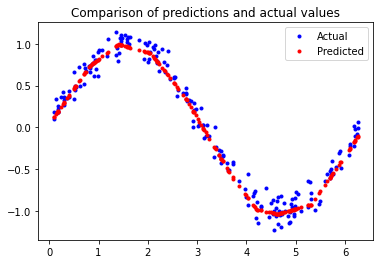

In [15]:
# Calculate and print the loss on our test dataset
loss = model_2.evaluate(x_test, y_test)

# Make predictions based on our test dataset
predictions = model_2.predict(x_test)

# Graph the predictions against the actual values
plt.clf()
plt.title('Comparison of predictions and actual values')
plt.plot(x_test, y_test, 'b.', label='Actual')
plt.plot(x_test, predictions, 'r.', label='Predicted')
plt.legend()
plt.show()

Much better! The evaluation metrics we printed show that the model has a low loss and MAE on the test data, and the predictions line up visually with our data fairly well.

The model isn't perfect; its predictions don't form a smooth sine curve. For instance, the line is almost straight when `x` is between 4.2 and 5.2. If we wanted to go further, we could try further increasing the capacity of the model, perhaps using some techniques to defend from overfitting.

However, an important part of machine learning is knowing when to quit, and this model is good enough for our use case - which is to make some LEDs blink in a pleasing pattern.

## Convert to TensorFlow Lite
We now have an acceptably accurate model in-memory. However, to use this with TensorFlow Lite for Microcontrollers, we'll need to convert it into the correct format and download it as a file. To do this, we'll use the [TensorFlow Lite Converter](https://www.tensorflow.org/lite/convert). The converter outputs a file in a special, space-efficient format for use on memory-constrained devices.

Since this model is going to be deployed on a microcontroller, we want it to be as tiny as possible! One technique for reducing the size of models is called [quantization](https://www.tensorflow.org/lite/performance/post_training_quantization). It reduces the precision of the model's weights, which saves memory, often without much impact on accuracy. Quantized models also run faster, since the calculations required are simpler.

The TensorFlow Lite Converter can apply quantization while it converts the model. In the following cell, we'll convert the model twice: once with quantization, once without:

In [16]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model_2)
tflite_model = converter.convert()

# Save the model to disk
open("sine_model.tflite", "wb").write(tflite_model)

# Convert the model to the TensorFlow Lite format with quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model_2)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

# Save the model to disk
open("sine_model_quantized.tflite", "wb").write(tflite_model)

2816

## Test the converted models
To prove these models are still accurate after conversion and quantization, we'll use both of them to make predictions and compare these against our test results:

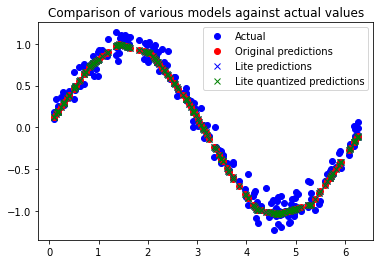

In [17]:
# Instantiate an interpreter for each model
sine_model = tf.lite.Interpreter('sine_model.tflite')
sine_model_quantized = tf.lite.Interpreter('sine_model_quantized.tflite')

# Allocate memory for each model
sine_model.allocate_tensors()
sine_model_quantized.allocate_tensors()

# Get the input and output tensors so we can feed in values and get the results
sine_model_input = sine_model.tensor(sine_model.get_input_details()[0]["index"])
sine_model_output = sine_model.tensor(sine_model.get_output_details()[0]["index"])
sine_model_quantized_input = sine_model_quantized.tensor(sine_model_quantized.get_input_details()[0]["index"])
sine_model_quantized_output = sine_model_quantized.tensor(sine_model_quantized.get_output_details()[0]["index"])

# Create arrays to store the results
sine_model_predictions = np.empty(x_test.size)
sine_model_quantized_predictions = np.empty(x_test.size)

# Run each model's interpreter for each value and store the results in arrays
for i in range(x_test.size):
  sine_model_input().fill(x_test[i])
  sine_model.invoke()
  sine_model_predictions[i] = sine_model_output()[0]

  sine_model_quantized_input().fill(x_test[i])
  sine_model_quantized.invoke()
  sine_model_quantized_predictions[i] = sine_model_quantized_output()[0]

# See how they line up with the data
plt.clf()
plt.title('Comparison of various models against actual values')
plt.plot(x_test, y_test, 'bo', label='Actual')
plt.plot(x_test, predictions, 'ro', label='Original predictions')
plt.plot(x_test, sine_model_predictions, 'bx', label='Lite predictions')
plt.plot(x_test, sine_model_quantized_predictions, 'gx', label='Lite quantized predictions')
plt.legend()
plt.show()


We can see from the graph that the predictions for the original model, the converted model, and the quantized model are all close enough to be indistinguishable. This means that our quantized model is ready to use!

We can print the difference in file size:

In [18]:
import os
basic_model_size = os.path.getsize("sine_model.tflite")
print("Basic model is %d bytes" % basic_model_size)
quantized_model_size = os.path.getsize("sine_model_quantized.tflite")
print("Quantized model is %d bytes" % quantized_model_size)
difference = basic_model_size - quantized_model_size
print("Difference is %d bytes" % difference)

Basic model is 2704 bytes
Quantized model is 2816 bytes
Difference is -112 bytes


Our quantized model is only 16 bytes smaller than the original version, which only a tiny reduction in size! At around 2.6 kilobytes, this model is already so small that the weights make up only a small fraction of the overall size, meaning quantization has little effect.

More complex models have many more weights, meaning the space saving from quantization will be much higher, approaching 4x for most sophisticated models.

Regardless, our quantized model will take less time to execute than the original version, which is important on a tiny microcontroller!

## Write to a C file
The final step in preparing our model for use with TensorFlow Lite for Microcontrollers is to convert it into a C source file. You can see an example of this format in [`hello_world/sine_model_data.cc`](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/micro/examples/hello_world/sine_model_data.cc).

To do so, we can use a command line utility named [`xxd`](https://linux.die.net/man/1/xxd). The following cell runs `xxd` on our quantized model and prints the output:

In [19]:
# Install xxd if it is not available
#!apt-get -qq install xxd
# Save the file as a C source file
!date
!xxd -i sine_model_quantized.tflite > sine_model_quantized.cc
# Print the source file
!cat sine_model_quantized.cc

Sat 28 Nov 2020 07:58:03 AM PST
unsigned char sine_model_quantized_tflite[] = {
  0x20, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x00, 0x00, 0x00, 0x00,
  0x00, 0x00, 0x12, 0x00, 0x1c, 0x00, 0x04, 0x00, 0x08, 0x00, 0x0c, 0x00,
  0x10, 0x00, 0x14, 0x00, 0x00, 0x00, 0x18, 0x00, 0x12, 0x00, 0x00, 0x00,
  0x03, 0x00, 0x00, 0x00, 0xb8, 0x0a, 0x00, 0x00, 0x70, 0x06, 0x00, 0x00,
  0x58, 0x06, 0x00, 0x00, 0x3c, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00,
  0x01, 0x00, 0x00, 0x00, 0x0c, 0x00, 0x00, 0x00, 0x08, 0x00, 0x0c, 0x00,
  0x04, 0x00, 0x08, 0x00, 0x08, 0x00, 0x00, 0x00, 0x08, 0x00, 0x00, 0x00,
  0x0b, 0x00, 0x00, 0x00, 0x13, 0x00, 0x00, 0x00, 0x6d, 0x69, 0x6e, 0x5f,
  0x72, 0x75, 0x6e, 0x74, 0x69, 0x6d, 0x65, 0x5f, 0x76, 0x65, 0x72, 0x73,
  0x69, 0x6f, 0x6e, 0x00, 0x0c, 0x00, 0x00, 0x00, 0x08, 0x06, 0x00, 0x00,
  0xf4, 0x05, 0x00, 0x00, 0x98, 0x05, 0x00, 0x00, 0x34, 0x05, 0x00, 0x00,
  0x20, 0x05, 0x00, 0x00, 0xcc, 0x04, 0x00, 0x00, 0xb8, 0x00, 0x00, 0x00,
  0x64, 0x00, 0x00, 0x00, 0x58, 

We can either copy and paste this output into our project's source code, or download the file using the collapsible menu on the left hand side of this Colab.

